In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from growingspheres import counterfactuals as cf

PATH = ''## To update

# Example: Growing Spheres for 1 prediction

### 2D Illustrative

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble, tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib import pyplot as plt

X,y = datasets.make_moons(n_samples = 200, shuffle=True, noise=0.05, random_state=0)
X = (X.copy() - X.mean(axis=0))/X.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(' ### Accuracy:', sum(clf.predict(X_test) == y_test)/y_test.shape[0])

def plot_classification_contour(X, clf, ax=[0,1]):
    ## Inspired by scikit-learn documentation
    h = .02  # step size in the mesh
    cm = plt.cm.RdBu
    x_min, x_max = X[:, ax[0]].min() - .5, X[:, ax[0]].max() + .5
    y_min, y_max = X[:, ax[1]].min() - .5, X[:, ax[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    #plt.sca(ax)
    plt.contourf(xx, yy, Z, alpha=.5, cmap=cm)


 ### Accuracy: 1.0


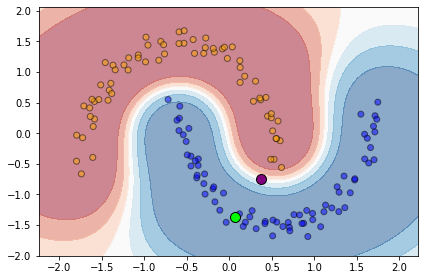

In [3]:
idx = np.random.randint(X_test.shape[0])
obs = X_test[idx, :].reshape(1, -1)

CF = cf.CounterfactualExplanation(obs, clf.predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=False, verbose=False)
cf_x = CF.enemy.reshape(1, -1)

plot_classification_contour(X_test, clf)
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', edgecolors='k', alpha=0.5, color=[['orange', 'blue'][i] for i in y_train])
plt.scatter(obs[:,0], obs[:,1], marker='o', color='lime', edgecolors='k', s=100)
plt.scatter(cf_x[:,0], cf_x[:,1], marker='o', color='purple', edgecolors='k', s=100)
plt.tight_layout()





### Try Iris Dataset

In [4]:
from sklearn.datasets import load_iris
data = load_iris()
data.target[[10, 25, 50]]

array([0, 0, 1])

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

In [6]:
clf = SVC()
clf = clf.fit(X_train, y_train)

In [7]:
clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2])

In [8]:
#idx = np.random.randint(X_test.shape[0])
obs = X_test[3, :].reshape(1, -1)

CF = cf.CounterfactualExplanation(obs, clf.predict, method='GS')
CF.fit(n_in_layer=200, first_radius=0.1, dicrease_radius=10, sparse=False, verbose=True)
cf_x = CF.enemy.reshape(1, -1)

0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  110
Final radius:  (1.9720000000000013, 1.9900000000000013)
Final number of ennemies:  1


In [9]:
cf_x

array([[5.83405085, 3.63067112, 2.79288611, 0.84301528]])

In [10]:
clf.predict(cf_x)

array([0])

In [11]:
clf.predict(X_test[3].reshape(1,-1))

array([1])

### MNIST Examples  💥😊💥

In [12]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)

TF version:  2.4.1


In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

xmin, xmax = -0.5,0.5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [14]:
classifier = SVC(gamma=0.05, kernel='rbf')

In [15]:
x_train_flat = x_train.reshape(60000, 28*28)
y_train_flat = np.argmax(y_train, axis=1)

In [16]:
x_test_flat = x_test.reshape(10000, 28*28)
y_test_flat = np.argmax(y_test, axis=1)

In [17]:
classifier.fit(x_train_flat[0:6000], y_train_flat[0:6000]) #fit on a subset of train data

SVC(gamma=0.05)

In [18]:
classifier.predict(x_test_flat[0].reshape(1,-1))

array([7], dtype=int64)

In [19]:
obs = x_test_flat[3, :].reshape(1, -1)

CF = cf.CounterfactualExplanation(obs, classifier.predict, method='GS')

In [20]:
obs.shape

(1, 784)

In [21]:
CF.fit(n_in_layer=200, first_radius=1, dicrease_radius=0.8, sparse=False, verbose=True)

0 ennemies found in initial sphere. Zooming in...
Exploring...


OverflowError: (34, 'Result too large')